#### Gemini Guide 

#### 진행 현황
* node 가이드 코드 동작 확인 완료
* node 가이드 코드 분석 중

* 문제점 확인 및 개선 중
  * 일부 배경이 사람으로 인식되는 문제
    * Connected Components 로 개선 확인 완료
  * 옷이 사람으로 인식되는 문제 확인 중


In [2]:
#------------------------------------------------------------------
# TITLE : 3.인물사진을 만들어 보자
#   세그멘테이션, 사람 분리하기.
#   Semantic Segmentation(시맨틱 세그멘테이션) 
#------------------------------------------------------------------

# %%
import cv2
import os
import numpy as np
import torch
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet101
import matplotlib.pyplot as plt

from pathlib import Path

def show_seperator(msg):
    print("-"*60)
    print(msg)
    print("-"*60)

def show_log(msg):
    print("### " + msg)

------------------------------------------------------------
1. 환경 설정 및 이미지 로드
------------------------------------------------------------


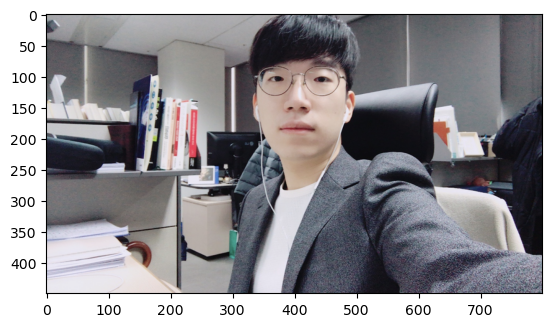

/home/torious/anaconda3/envs/modulab/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/torious/anaconda3/envs/modulab/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
#------------------------------------------------------------------
show_seperator("1. 환경 설정 및 이미지 로드")
#------------------------------------------------------------------

def get_image(env):
    if env == "NODE":
        # home_dir = os.getenv('HOME')
        # img_path = os.path.join(home_dir, "work/human_segmentation/images/my_image.png")
        # img_orig = cv2.imread(img_path)

        # print(f"이미지 크기: {img_orig.shape}")
        # home_dir = os.getenv('HOME')
        pass

    elif env == "WSL.PY":
        base_path = Path(__file__).resolve().parent
        img_path = base_path / "images" / "my_image.png"
        return img_path

    elif env == "WSL.IPYNB":
        base_path = Path(os.getcwd())
        img_path = base_path / "images" / "my_image.png"
        return img_path

img_path = get_image("WSL.IPYNB")
img_orig = cv2.imread(img_path)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

model = deeplabv3_resnet101(pretrained=True).eval()
transform = T.Compose([
    T.ToPILImage(),
    T.Resize((520, 520)),   
    T.ToTensor(),           # 이미지를 PyTorch 텐서(0~1 사이 값)로 변환
])

input_tensor = transform(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)).unsqueeze(0)


In [6]:
#------------------------------------------------------------------
show_seperator("2. 모델 추론 (Inference)")
#------------------------------------------------------------------
with torch.no_grad():
    # 추론 : 각 픽셀이 어떤 클래스에 속하는지 확률 값을 구하고
    output = model(input_tensor)["out"][0]

    # 결과 추출: argmax(0)를 사용하여 가장 확률이 높은 클래스 번호(ID)만 남긴다. 
    output_predictions = output.argmax(0).byte().cpu().numpy()

#------------------------------------------------------------------
show_seperator("3. 후처리 및 결과 복원")
#------------------------------------------------------------------
# 원본 크기로 Resize 
# Resize: cv2.INTER_NEAREST 보간법 사용 : 클래스 ID(정수)가 깨지지 않도록 가장 가까운 이웃 값을 참조하는 방식
output_predictions_resized = cv2.resize(output_predictions, 
                                        (img_orig.shape[1], img_orig.shape[0]), 
                                        interpolation=cv2.INTER_NEAREST)

------------------------------------------------------------
2. 모델 추론 (Inference)
------------------------------------------------------------
------------------------------------------------------------
3. 후처리 및 결과 복원
------------------------------------------------------------


------------------------------------------------------------
4. 마스크 생성 및 시각화 확인 - 1
------------------------------------------------------------


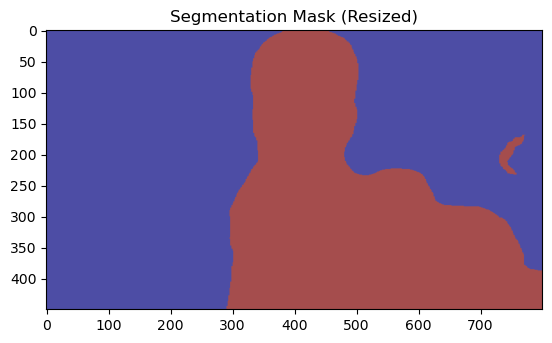

[ 0 15]
background
person


In [7]:
#------------------------------------------------------------------
show_seperator("4. 마스크 생성 및 시각화 확인 - 1")
#------------------------------------------------------------------
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

# 각 픽셀의 클래스 번호에 따라 무지개색(jet)을 입히고, 70% 정도의 농도로 화면에 그린다. 
# 1. output_predictions_resized
#   이미지의 각 픽셀마다 **"이 픽셀은 무슨 물체인가"**에 대한 번호(ID)가 들어있습니다.
#   배경은 0, 자동차는 7, 사람은 15 같은 정수 데이터입니다.
#   그냥 출력하면 숫자가 너무 작아서(0~20) 거의 검은색으로만 보이게 됩니다.

# 2. cmap="jet" (컬러맵)
#   숫자 데이터에 **색상 지도(Color Map)**를 입히는 설정입니다.
#   jet: 아주 낮은 값은 파란색, 중간은 초록색/노란색, 높은 값은 빨간색으로 표현하는 방식입니다.
#   이 설정을 통해 0(배경)은 파란색 계열로, 15(사람)는 주황/빨간색 계열로 확연히 구분되어 보이게 됩니다.

# 3. alpha=0.7 (투명도)
#   범위는 **0.0(완전 투명)**에서 1.0(완전 불투명) 사이입니다.
#   0.7은 약간 투명하게
plt.imshow(output_predictions_resized, cmap="jet", alpha=0.7)
plt.title("Segmentation Mask (Resized)")
plt.show()

# 1. np.unique()
#       중복된 값들을 제거하고, 고유 값들만 오름차순으로 정렬하여 반환
#       입력: output_predictions_resized (수만 개의 픽셀이 각각 0~20 사이의 클래스 ID를 가짐)
#       unique_classes → [0, 15]
unique_classes = np.unique(output_predictions_resized)
print(unique_classes)               # unique_classes → [0, 15]
for class_id in unique_classes:
    print(LABEL_NAMES[class_id])    # background, person     


------------------------------------------------------------
4. 마스크 생성 및 시각화 확인 - 2 - 컬러맵 생성
------------------------------------------------------------


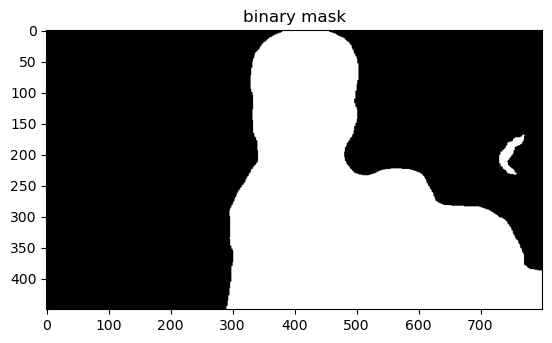

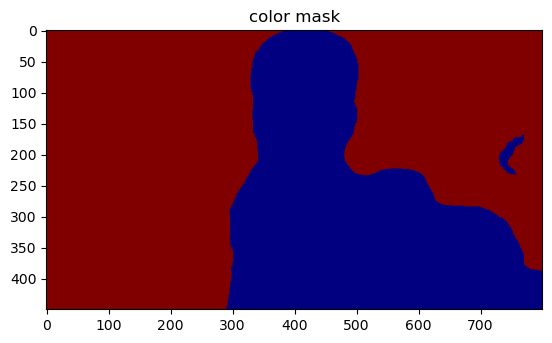

In [8]:
#------------------------------------------------------------------
show_seperator("4. 마스크 생성 및 시각화 확인 - 2 - 컬러맵 생성")
#------------------------------------------------------------------
# 클래스 번호(ID)로 고유한 RGB 색상을 뱉어주는 색상표를 생성

# 도화지 준비
colormap = np.zeros((256, 3), dtype=int)

# 인덱스 배열 생성
ind = np.arange(256, dtype=int) # index 

# color map을 생성한다. 
for shift in reversed(range(8)):                # 채널당 8bit : MSB 부터 설정
    for channel in range(3):                    # 0:Red, 1:Green, 2:Blue 채널별 작업
        # 클래스 번호의 특정 비트를 추출하여 R, G, B 채널에 배치
        colormap[:, channel] |= ((ind >> channel) & 1) << shift    
    ind >>= 3

# print(colormap[:20])       # 생성한 20개의 컬러맵 출력
# print(colormap[15])        # 컬러맵 15에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 15번째인 사람)

# 원본 이미지와 합치기 위한 이미지 형태의 마스크 생성 
seg_map = (output_predictions_resized == 15)    # 클래스 ID 15 (사람)만 골라서, Boolean Map 생성 
img_mask = seg_map.astype(np.uint8) * 255       # 0, 255 로 구성된 binary mask 생성
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)  # 흑백 이미지에 특정 테마(JET)의 색상 적용

plt.imshow(img_mask, cmap='gray')  
plt.title("binary mask")
plt.show()

plt.imshow(color_mask)
plt.title("color mask")
plt.show()

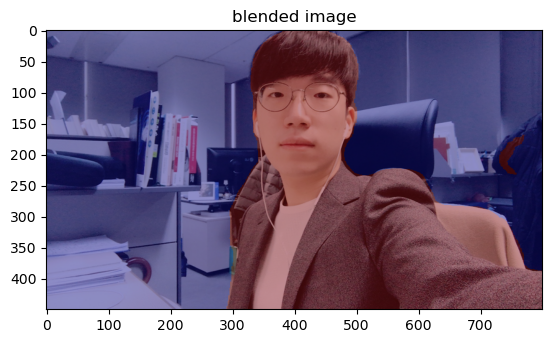

In [9]:
# 직관과 반대인 이유: OpenCV(BGR)와 Matplotlib(RGB)이 색상을 읽는 순서가 거꾸로라서 
# JET 컬러맵의 특성: JET은 낮은 값을 파란색, 높은 값을 빨간색으로 배정하는데, 
# 이 채널 순서가 꼬이면 반대의 색으로 보이게 된다.

# 이미지 합치기 - 원본 (60%), 컬러 마스크(40%)
img_show = cv2.addWeighted(img_orig, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.title("blended image")
plt.show()

------------------------------------------------------------
5. 배경 흐리게 하기
------------------------------------------------------------


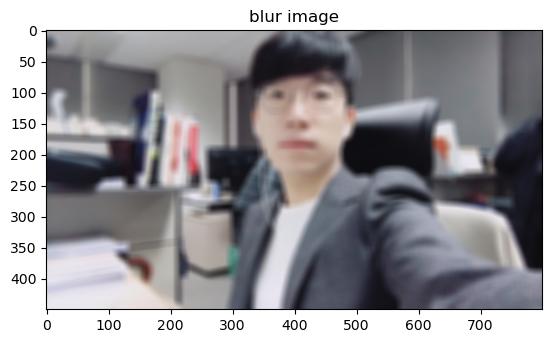

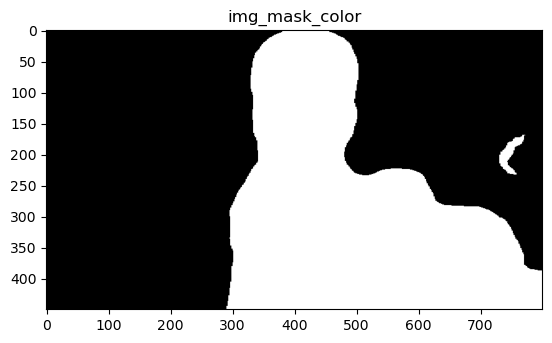

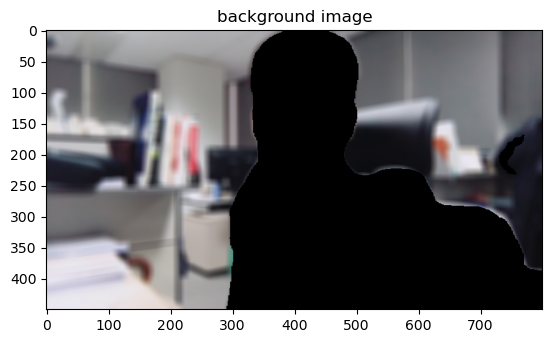

------------------------------------------------------------
6. 흐린 배경과 원본 영상 합성
------------------------------------------------------------


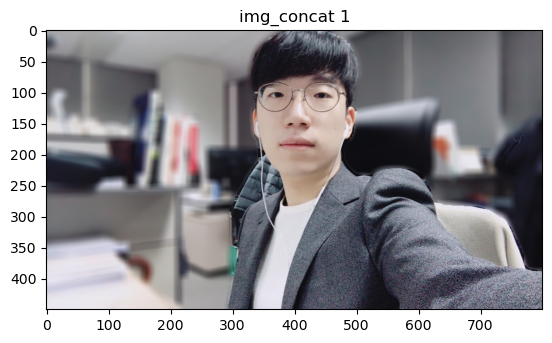

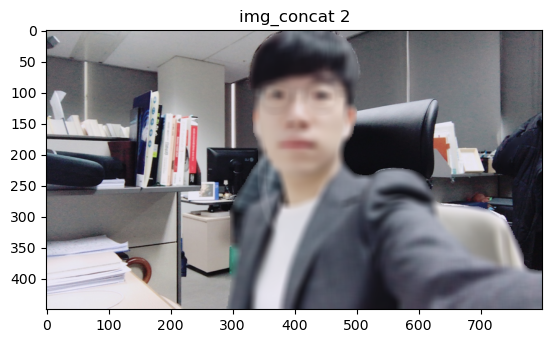

In [10]:
#------------------------------------------------------------------
show_seperator("5. 배경 흐리게 하기")
#------------------------------------------------------------------

# 커널 사이즈(13, 13) -> 클수록 많이 뭉게진다.
img_orig_blur = cv2.blur(img_orig, (13, 13))

plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.title("blur image")
plt.show()

# 흑백(1채널) -> BGR(3채널)로 변경 : 이미지는 여전히 흑백으로 보인다.
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
plt.imshow(cv2.cvtColor(img_mask_color, cv2.COLOR_BGR2RGB))
plt.title("img_mask_color")
plt.show()

img_bg_mask = cv2.bitwise_not(img_mask_color) # 배경 mask를 black -> white로 변경
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)

plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.title("background image")
plt.show()

#------------------------------------------------------------------
show_seperator("6. 흐린 배경과 원본 영상 합성")
#------------------------------------------------------------------

# np.where(조건, A, B)
#   모든 픽셀마다 조건 True -> A, False -> B 적용
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.title("img_concat 1")
plt.show()

# 사람을 blur, 배경을 원본으로 출력 
img_concat = np.where(img_mask_color == 255, img_orig_blur, img_orig)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.title("img_concat 2")
plt.show()

------------------------------------------------------------
10. 현재 문제점 확인 및 개선
------------------------------------------------------------
### False Positive 개선 - GrabCut, Connected Components 적용


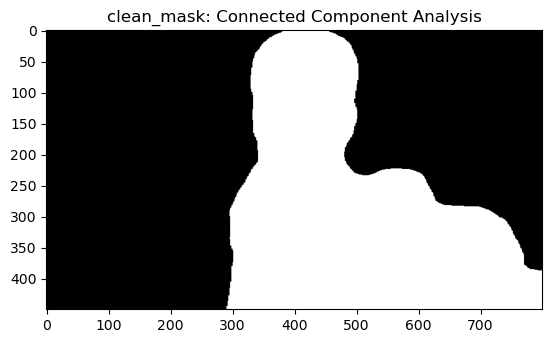

In [ ]:
#------------------------------------------------------------------
show_seperator("10. 현재 문제점 확인 및 개선 - 확인 중")
#------------------------------------------------------------------

show_log("False Positive 개선 - GrabCut, Connected Components 적용")

# 1. 떨어진 배경 제거: Connected Component Analysis : 효과 있음.
# 사람 마스크 중에서 가장 덩어리가 큰 것(진짜 사람)만 남기고 나머지는 다 지워라

# 0과 255로 된 이진 마스크에서 덩어리(Label) 찾기
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(img_mask)

# 2. 배경(0번)을 제외하고 가장 면적이 큰 덩어리 인덱스 찾기
if num_labels > 1:
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    
    # 3. 가장 큰 덩어리만 남긴 새로운 마스크 생성
    clean_mask = np.zeros_like(img_mask)
    clean_mask[labels == largest_label] = 255
else:
    clean_mask = img_mask

plt.imshow(cv2.cvtColor(clean_mask, cv2.COLOR_BGR2RGB))
plt.title("clean_mask: Connected Component Analysis")
plt.show()


# # 2. 옷/테두리 정밀 수정: GrabCut (수동 가이드 추가)
    
# #   1. 사람(clean_mask)이 있는 최소한의 사각형 영역 찾기
# x, y, w, h = cv2.boundingRect(clean_mask)
# rect = (x, y, x + w, y + h)

# # print(x, y, w, h)
# # cv2.rectangle(img_orig, (x, y), (x + w, y + h), (255,255,255), 2, lineType=cv2.LINE_AA)
# # plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
# # plt.title("rect")
# # plt.show()

# #   2. GrabCut 설정
# bgdModel = np.zeros((1, 65), np.float64)
# fgdModel = np.zeros((1, 65), np.float64)

# #   3. 사각형 정보를 주어 GrabCut 실행 (이미지, 마스크, 사각형 순)
# #       이 과정에서 옷의 질감과 피부 색상을 분석해 더 정확하게 경계를 나눕니다.
# cv2.grabCut(img_orig, clean_mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

# #   4. 결과 정리
# final_mask = np.where((clean_mask == 2) | (clean_mask == 0), 0, 1).astype('uint8')

# plt.imshow(cv2.cvtColor(final_mask, cv2.COLOR_BGR2RGB))
# plt.title("final_mask: GrabCut")
# plt.show()

# # 이미지 합치기 - 원본 (60%), 컬러 마스크(40%)
# img_show = cv2.addWeighted(img_orig, 0.6, final_mask, 0.4, 0.0)

# plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
# plt.title("blended image - 2")
# plt.show()





# # %%
# show_log(" Try #1 : 3. 결과 후처리 (Post-processing) : cv2.morphologyEx() 적용")
# # 개선 효과 미미, 방향이 다른 듯 

# # 1. 커널 설정 : (5, 5) 숫자가 커질수록 더 강력하게 깎거나 채운다. 
# kernel_size = 10
# kernel = np.ones((kernel_size, kernel_size), np.uint8)

# # 2. Opening: 배경에 흩뿌려진 작은 노이즈(흰 점) 제거
# img_mask_opened = cv2.morphologyEx(img_mask, cv2.MORPH_OPEN, kernel)

# # 3. Closing: 고양이 내부의 작은 검은 구멍이나 갈라진 틈 채우기
# img_mask_refined = cv2.morphologyEx(img_mask_opened, cv2.MORPH_CLOSE, kernel)

# # 결과 확인
# plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 1)
# plt.title("Original Mask")
# plt.imshow(img_mask, cmap='gray')

# plt.subplot(1, 2, 2)
# plt.title(f"Refined Mask (Morphology) (K {kernel_size}x{kernel_size})")
# plt.imshow(img_mask_refined, cmap='gray')
# plt.show()

# # %%
